# An Introduction to Neural Networks


* An Introduction to Probabilistic Graphical Models (Skip)
    * Bayesian Networks
    * Hidden Markov Chains
* A review of linear regression
    * linear algebra review
        * row reduction of a matrix 
        * matrix multiplication
        * invertability
    * Implementing linear regression with linear algebra
* Neural Networks
    * Chain Rule over vector spaces
    * psuedo code
    * implementing a basic neural network in raw python
        * Forward propagation
        * Back propagation
    * Issues in convergence
        * vanishing gradient
        * exploding gradient
    * introduction to keras
        * A simple example - regression
        * A simple example - classification
        * neural network architecture design
            * final layer for regression
            * final layer for classification
            * regularization
    * Surogate Models
        * linear regression
        * decision trees
            * feature importance
            * tre interpreter
    * SHAP
        * regression example
        * classification example

# A Review of Linear Regression

In the first part of this tutorial we saw how to implement linear regression using calculus.  In order to build comfort with matrices, which are a central core notion in the design and implementation of neural networks, we will review how to implement linear regression, except this time, using the framing of linear algebra.

The other reason it is helpful to recall our notions around linear regression is neural networks draw from linear regression.  The simplest possible neural network is actually just a set of chained linear regressions.  The power of neural networks is in how one does the chaining of course.  That said, neural nets can be far more complex, interesting, powerful and difficult to understand.  

Finally, it's easy to get lost in all the machinery and choices of neural networks so it's important to ground them in context - neural networks just solve an optimization problem, minimizing error like any other algorithm.  And typically, the way they do that is via Stochastic Gradient Descent.

## A Review of Stochastic Gradient Descent

Recall the following picture:

In [3]:
from IPython.display import HTML
HTML('<img src="NewtonIteration_Ani.gif">')

In it, we can see broadly how gradient descent works - we start with some initial guess, then we use the gradient (which is the same as a derivative) to update that guess and get closer to an optimum.  Optimums are the minimums or maximums of your function, depending on what you are trying to do.  In the case of gradient descent, you are trying to minimize loss, that is the difference between your predicted outcomes and the outcomes you saw in your training data.

## A Review of Linear Algebra

In the previous implementation of Gradient Descent we made use of the derivative directly via calculus to find our optimum, minimizing error.  However, in practice most algorithms make use of the linear algebra formulation of Gradient Descent because linear algebra is extremely power and we have many computational tricks to make it fast.

Before we dive into the implementation, let's review some concepts from linear algebra to get a sense of how to work with matrices and vectors, the mainstays of the subfield.

### Motivating Linear Algebra

One of the general goals of linear algebra is to be able to solve sets of equations simultaneously.  First, let's see how to solve a single equation using simple python:

In [4]:
def equation_one(x):
    return x

def find_zero_eq_one():
    for i in range(-100, 100):
        if equation_one(i) == 0:
            return i
        
print("The 'zero' for equation one is", find_zero_eq_one())

The 'zero' for equation one is 0


Easy enough!  This is the simplest possible way we could "solve" an equation, just guess and check.  Now let's see if this method get's more complex when we make our equation more sophisticated!

In [5]:
def equation_two(x):
    return x + 7

def find_zero_eq_two():
    for i in range(-100, 100):
        if equation_two(i) == 0:
            return i
        
print("The 'zero' for equation two is", find_zero_eq_two())

The 'zero' for equation two is -7


Here we've added a constant, thus changing our equation.  Still pretty simple and we can reuse our solver!  What happens when we go to two variables and add coeficients on our variables?

In [6]:
def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step

def equation_four(x, y):
    return 5*x + 4*y + 7

def find_zero_eq_four(episolon):
    for i in arange(-10, 10, 0.1):
        for j in arange(-10, 10, 0.1):
            if abs(equation_four(i, j)) < episolon:
                return (i, j)
        
print("The 'zero' for equation four is", find_zero_eq_four(0.01))

The 'zero' for equation four is (-9.400000000000002, 9.999999999999963)


Notice, now we need two for loops and also, we can no longer make use of the built-in range function.  Instead, we need access to a far more granular set of numbers - the floating points, instead of the integers.  This also means that we can no longer have equality in our stopping condition:

`if abs(equation_four(i, j)) < episolon`

Now we need set a tolerance for acceptance, a them of many data science algorithms, because typically we work with floating point numbers which (almost) never converge to an integer value.

Let's add yet another variable just to drive the point home:

In [8]:
def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step
        
def equation_four_plus(x, y, z):
    return 5*x + 4*y + 8*z + 7

def find_zero_eq_four_plus(episolon):
    for i in arange(-10, 10, 0.1):
        for j in arange(-10, 10, 0.1):
            for k in arange(-10, 10, 0.1):
                if abs(equation_four_plus(i, j, k)) < episolon:
                    return (i, j, k)
        
print("The 'zero' for equation four plus is", find_zero_eq_four_plus(0.01))

The 'zero' for equation four plus is (-9.8, -9.500000000000002, 9.999999999999963)


Here we see things get even worse!  And now we need 3 for loops!  With every variable we add to a single equation, using classical techniques, like for loops, we will run into trouble fast.  Computationally speaking, linear algebra can make our lives significantly easier, producing algorithms that can solve systems of equations, that is many equations needing to be solved together much faster than the simple for loop scheme we have defined above.

This is the reason no one uses calculus to solve gradient descent, the algorithm simply does not scale the same way.  And with a neural network, you may need to solve thousands or millions of equations simultaneously (typically hundreds).  

Just for completeness, let's look at how to write down how to solve a single equation with an arbitrary number of variables:

In [2]:
from functools import partial
import itertools


def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step

        
def equation_five(coefficients, constant, variables):
    return sum([coefficients[index]*variables[index] 
                for index in range(len(variables))]) + constant


def find_zero_eq_five(coefficients, constant, episolon):
    eq_five = partial(equation_five, coefficients, constant)
    value_range = list(arange(-10, 10, 0.1))
    values = list(itertools.permutations(value_range, len(coefficients)))
    for value in values:        
        if abs(eq_five(value)) < episolon:
                return value

print(find_zero_eq_five([1], 7, 0.1))
print(find_zero_eq_five([1, 2], 7, 0.1))
#print(find_zero_eq_five([1, 2, 3], 7, 0.1))
#print(find_zero_eq_five([1, 2, 3, 4], 7, 0.1))

(-7.000000000000011,)
(-10, 1.4999999999999816)


The reason this solver looks a little more compact is not because it's solving fewer equations, it's because it's getting all the for loops upfront via the permutations function.  This little computational trick makes things a little more tractable computationally speaking, but it doesn't give us enough of a boost to make things tenable.  I could in fact break this notebook just by running the third or fourth example.

## Matrices

We've worked with a few algorithms a lot.  Now we'll introduce a new data structure - the matrix.  A matrix mathematically speaking is a notational convention.  More or less a matrix is just a vector of vectors.  And a vector is just the coefficients of a linear equation.  We've been implicitly using mathematical vectors since we introduced equations above.

## A first example of matrices, Supply and Demand

Let's say that we own and operate a business that sells candy bars.  Assume there is implicit demand for candy bars and many other candy bar sellers.  However, assume our costs are perhaps slightly different from other candy bar sellers, so we can choose what price to sell our candy bar at, subject to our ability to supply candy.  We can also assume we have some supply control because most people aren't patient about candy, they want it when they want it.  So if someone happens by your shop, the price may actually effect their decision to buy the candy or not.

So let's say you have a supply function like:

`price = 2*quantity + 3`

What this equation says is as a business owner, as the price increases you'll want to supply more candy bars, because the perception is, you'll make more money.  

Let's also say there is a demand function like:

`price = 3 - 2*quantity`

This equation says the price you can charge is subject to how many candy bars you make.  So if your shop is filled to the brim and your the only local vendor around, folks will likely be able to always satisfy their craving for candy.  And if you only make a single candy bar, folks will be willing to pay a lot to be the only one to get it.  Because candy is delicious.

Given the above equations we need both the supply and demand equation to find the unique equilibrium of price and quantity such that the market for candy bars is in balance.  This balancing point, all other things held constant, will be the price that maximizes utility for the buyers of candy bars as well as the sellers of candy bars.  And since we are treating our example as idealized, we are in a capitalism regime where the intention is to maximize utility for all.  However, even with the introduction of immorality and therefore businesses or agents acting in subversive ways, all economies are still subject to the above laws generally speaking and therefore understanding this idealized situation still yields value.

So!  Now that we have our supply and demand equations, how do we find the unique price, quantity that yields our equilibrium?  With matrices of course!

First we'll need to turn these equations into the appropriate form:

Supply:

`price - 2*quantity = 3`

Demand:

`price + 2*quantity = 3`

We need to do this so all the variables are on one side of the equation.  Now we can do this:

Supply/Demand Matrix:

$$
  \begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} 
  \begin{bmatrix} 3 \\ 3 \end{bmatrix}
$$

Now we have the two resulting mathematical objects, a matrix describing the coeficients of the two equations and a vector describing the solution space.  We'll do something called row reduction on the matrix which will produce unique solutions for the equations.  Before we carry out these operations notice that if our matrix looks like this:

$$
  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
  \begin{bmatrix} a \\ b \end{bmatrix}
$$


Then whatever our variables are, they are equal to a and b respectively.  Because the matrix:

$$
  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
$$

Translates to

$$
  \begin{bmatrix} x \\ y \end{bmatrix}
$$

With the `[a b]` vector this becomes:

$$
x = a \\
y = b
$$

Which solves x and y uniquely!  So now we'll do row reduction to create a matrix which looks like the above one.  And then we'll apply the changes we used on the matrix, onto the solution vector as well.  Which will in turn solve our system of equations!


$\begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} $

```
(R[1] = R[1] + R[2])
------------------->
``` 

$ \begin{bmatrix} 2 & 0 \\ 1 & 2 \end{bmatrix} $

```
(R[1] = R[1]/2)
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 1 & 2 \end{bmatrix} $

```
(R[2] = R[2] - R[1])
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix} $

```
(R[2] = R[2]/2)
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $

 
Now we'll simply apply the changes to the matrix to the vector:

$ \begin{bmatrix} 3 \\ 3 \end{bmatrix} $

```
(R[1] = R[1] + R[2])
------------------->
``` 

$ \begin{bmatrix} 6 \\ 3 \end{bmatrix} $

```
(R[1] = R[1]/2)
------------------->
```

$ \begin{bmatrix} 3 \\ 3 \end{bmatrix} $

```
(R[2] = R[2] - R[1])
------------------->
```

$ \begin{bmatrix} 3 \\ 0 \end{bmatrix} $

```
(R[2] = R[2]/2)
------------------->
```

$ \begin{bmatrix} 3 \\ 0 \end{bmatrix} $


So the unique solution is:

```
price = 3
quantity = 0
```

What this ends up telling us is it's not possible to optimally operate our candy bar shop.  Which is pretty sad.  So this means we shouldn't open our candy bar shop.  Or we need to change our supply equation by becoming more efficient at producing candy bars.  Of course, it could also be the case that this is truly optimal because candy is bad for you :P.  But that's not really an economic analysis.

In any event, we are now ready to write a program which does row reduction for us, by solving a bunch of very simple equations.  Notice, what we really want is to make the numbers in the matrix that are not on the diagonal zero.  And then we want to make the numbers that are on the diagonal 1.  And then we need to store those operations and apply them to solution matrix.


In [4]:
from functools import partial
from random import random
from sys import setrecursionlimit

def eq_solver(val, func):
    if func(val) > 0:
        val -= 1
        return eq_solver(val, func)
    elif func(val) < 0:
        val += 1
        return eq_solver(val, func)
    else:
        return round(val, 5)
    
    
def eq_float_solver(val, eq, epsilon=0.0001, step_size=0.001, debug=False):
    if abs(eq(val)) < epsilon:
        return round(val, 5)
    elif eq(val) > 0:
        if debug:
            val -= step_size
            return eq_float_solver(val, eq)
        else:
            val -= step_size
            return eq_float_solver(val, eq)
    elif eq(val) < 0:
        if debug:
            val += step_size
            return eq_float_solver(val, eq)
        else:
            val += step_size
            return eq_float_solver(val, eq)
    else:
        return round(val, 5)


def eq_diag_solver(val, eq, epsilon=0.0001, step_size=0.001):
    if abs(eq(val)) - 1 < epsilon:
        return round(val, 5)
    elif eq(val) > 1:
        val -= step_size
        if val == 0:
            val -= step_size
        return eq_float_solver(val, eq)
    elif eq(val) < 1:
        val += step_size
        if val == 0:
            val += step_size
        return eq_float_solver(val, eq)
    else:
        return round(val, 5)
    

def arange(start, stop, step):
    cur = start
    while start < stop:
        yield cur
        cur += step

        
def iterative_solver(eq, start, stop, epsilon=0.0001, step_size=0.001):
    for val in arange(start, stop, step_size):
        if abs(eq(val)) < epsilon:
            return round(val, 5)


def flatten(matrix):
    listing = []
    for row in matrix:
        for elem in row:
            listing.append(elem)
    return listing


def solve_matrix(matrix):
    flattened_matrix = flatten(matrix)
    largest_value = max(flattened_matrix)
    num_zeros = len(str(largest_value))
    val_range = int("1" + "0"*num_zeros)
    steps = []
    cur_matrix = matrix
    for index in range(len(matrix)):
        col_index = index
        row_index = index
        cur_matrix, step = solve_diag(cur_matrix[col_index][row_index],
                                      row_index, col_index, cur_matrix, val_range)
        steps.append(step)
    for row_index in range(len(matrix[0])):
        for col_index in range(len(matrix)):
            if col_index == row_index:
                continue
            print(cur_matrix)
            step = solve_vector(cur_matrix[col_index][row_index], 
                                row_index, col_index, cur_matrix, val_range)
            cur_matrix = linear_combination(cur_matrix, step)
            print(col_index, row_index)
            steps.append(step)
    return steps, cur_matrix


def linear_combination(matrix, step):
    update_row = step[0]
    other_row = step[1]
    transformer = step[2]
    for index in range(len(matrix[0])):
        matrix[update_row][index] = transformer(
            matrix[update_row][index], matrix[other_row][index])
    return matrix
    

def solve_diag(elem, cur_elem_idx, diag_index, matrix, magnitude):
    reciprical = 1/elem
    matrix[diag_index] = [elem*reciprical 
                          for elem in matrix[diag_index]]
    operation = lambda coef, elem: elem*coef
    op = partial(operation, reciprical)
    step = [diag_index, cur_elem_idx, op, None, reciprical, "rescale"]
    return matrix, step


def solve_vector(elem, cur_elem_idx, diag_index, matrix, magnitude):
    for row_index, matrix_row in enumerate(matrix):        
        if matrix_row[cur_elem_idx] != 0 and row_index != diag_index:
            other_elem = matrix_row[cur_elem_idx]
            other_row = row_index
            break
    eq_to_solve = lambda elem, other_elem, coef: elem + coef*other_elem
    to_solve = partial(eq_to_solve, elem, other_elem)
    start, stop = magnitude*-1, magnitude
    coef = iterative_solver(to_solve, start=start, stop=stop)
    operation = lambda coef, elem, other: elem + coef*other
    op = partial(operation, coef)
    return [diag_index, cur_elem_idx, op, other_row, coef, "linear_combo"]


def apply_steps(vector, steps):
    for step in steps:
        if step[-1] == "linear_combo":
            idx = step[0]
            other_idx = step[3]
            coef = step[4]
            vector[idx] = vector[idx] + coef*vector[other_idx]
        else:
            idx = step[0]
            coef = step[4]
            vector[idx] = vector[idx]*coef
    return vector


#setrecursionlimit(10000)
if __name__ == '__main__':
    matrix = [[1, -2], [1, 2]]
    steps, cur_matrix = solve_matrix(matrix)
    print(apply_steps([3, 3], steps))


[[1.0, -2.0], [0.5, 1.0]]
1 0
[[1.0, -2.0], [0.0, 2.0]]
0 1
[3.0, 0.0]


I present the above solution for completeness, in case folks are interested in how to do this from scratch.  

## Matrix Operations (Digression)

Now that we've seen the power of matrices to allow us to solve systems of equations, let's briefly talk about some of their operations:

* Addition
* Multiplication

Matrix Addition is as simple as you'd suspect, simply go across and add each element in the same row column position:

$$
  \begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} 
  + 
  \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
  =
  \begin{bmatrix} 2 & -1 \\ 2 & 3 \end{bmatrix}
$$

Notice, the matrices are of the same size, and must be!  So that means you can't add two matrices of different shapes!

Next let's look at multiplication:

Matrix Multiplication is far more complicated, you have to go across the ith row and jth column to get the i,j entry.  This is best seen with an example:

$$
  \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} 
  * 
  \begin{bmatrix} 2 & 1 \\ 4 & 3 \end{bmatrix}
  =
  \begin{bmatrix} 10 & 7 \\ 22 & 15 \end{bmatrix}
$$

In order to recover the position at index 1, 1 (matrices are indexed starting at 1 in mathematical notation), you'd need to do:

$$ 1*2 + 2*4 = 10 $$

To make it clear what happens you take the first row of the first matrix: 1, 2 and multiply it by the first column of the second matrix: 2, 4 element by element and then sum the two multiplications.

This means that matrix multiplication is not communitive!  Which means:

$$ A*B \neq B* A $$

For matrices A and B.

Additionally, matrix mulitplication need not operate over matrices of the exact same size.  Therefore we can do things like this:

$$
  \begin{bmatrix} 1 & 2 & 3\\ 3 & 4 & 5\end{bmatrix} 
  * 
  \begin{bmatrix} 2 & 1 \\ 4 & 3 \\ 5 & 6 \end{bmatrix}
  =
  \begin{bmatrix} 25 & 25 \\ 47 & 45 \end{bmatrix}
$$

The only requirement is that our matrices be composable, that is, the number of columns of the first matrix is the same as the number of rows as the second matrix.  It's very important to understand how to compose matrices of different shapes because our individual layers of our neural network are in fact matrices.  If you try to compose two layers that can't be composed you will get a very annoying and confusing error.

For completeness, let's see how to do this in python!  Here we'll make use of numpy because the code for implementing fast matrix mulitplication is very confusing:

In [25]:
import numpy as np
A = np.array([[1, 2, 3], [3, 4, 5]])
B = np.array([[2, 1], [4, 3], [5, 6]])
print(np.dot(A, B))

[[25 25]
 [47 45]]


For completeness, here is the underlying multiplication written out:

In [2]:
class Matrix:
    def __init__(self,matrix):
        self.matrix = matrix
            
    def get_size(self):
        return len(self.matrix),len(self.matrix[0])

    def pprint(self):
        for row in self.matrix:
            print(row)
                
        
    def to_array(self):
        return self.matrix
        
    def get_elem(self,row,col):
        return self.matrix[row][col]    
        
    def __add__(self,other):
        row_size,col_size = self.get_size()
        new_matrix = []
        for row in range(row_size):
            new_matrix.append([elem+other.matrix[row][ind] for ind,elem in enumerate(self.matrix[row])])
        return Matrix(new_matrix)
    
    def __sub__(self,other):
        row_size,col_size = self.get_size()
        new_matrix = []
        for row in range(row_size):
            new_matrix.append([elem-other.matrix[row][ind] for ind,elem in enumerate(self.matrix[row])])
        return Matrix(new_matrix)

    def simple_multiplication(self,A,B):
        row_size,col_size = self.get_size()
        new_matrix = [[0 for i in range(row_size)] for j in range(row_size)]
        for i in range(row_size):
            for k in range(row_size):
                for j in range(row_size):
                    new_matrix[i][j] += A[i][k] * B[k][j]
        return Matrix(new_matrix)
    
    def __mul__(self,other):
        row_size,col_size = self.get_size()
        if row_size <= 2:
            return self.simple_multiplication(self.matrix,other.matrix)
        else:
            new_size = row_size//2
            A = [[0 for j in range(new_size)] for i in range(new_size)]
            B = [[0 for j in range(new_size)] for i in range(new_size)]
            C = [[0 for j in range(new_size)] for i in range(new_size)]
            D = [[0 for j in range(new_size)] for i in range(new_size)]

            E = [[0 for j in range(new_size)] for i in range(new_size)]
            F = [[0 for j in range(new_size)] for i in range(new_size)]
            G = [[0 for j in range(new_size)] for i in range(new_size)]
            H = [[0 for j in range(new_size)] for i in range(new_size)]

            for i in range(new_size):
                for j in range(new_size):
                    A[i][j] = self.matrix[i][j]
                    B[i][j] = self.matrix[i][j+new_size]
                    C[i][j] = self.matrix[i + new_size][j]
                    D[i][j] = self.matrix[i + new_size][j + new_size]

                    E[i][j] = other.matrix[i][j]
                    F[i][j] = other.matrix[i][j+new_size]
                    G[i][j] = other.matrix[i + new_size][j]
                    H[i][j] = other.matrix[i + new_size][j + new_size]

            A = Matrix(A)
            B = Matrix(B)
            C = Matrix(C)
            D = Matrix(D)
            E = Matrix(E)
            F = Matrix(F)
            G = Matrix(G)
            H = Matrix(H)
            
            p1 = A*(F-H)
            p2 = (A+B)*H
            p3 = (C+D)*E
            p4 = D*(G-E)
            p5 = (A+D)*(E+H)
            p6 = (B-D)*(G+H)
            p7 = (A -C)*(E+F)

            c11 = p5 + p4 - p2 + p6
            c12 = p1 + p2
            c21 = p3 + p4
            c22 = p1+ p5 - p3 - p7

            final = [[0 for j in range(row_size)] for i in range(row_size)]
            for i in range(new_size):
                for j in range(new_size):
                    final[i][j] = c11.matrix[i][j]
                    final[i][j+new_size] = c12.matrix[i][j]
                    final[i + new_size][j] = c21.matrix[i][j]
                    final[i + new_size][j + new_size] = c22.matrix[i][j]
            return Matrix(final)
            
A = Matrix([[1,2,4], [3,4,7], [1,12,15]])
B = Matrix([[2, 1, 6], [4, 3, 4], [1,1,1]])
(A*B).pprint()

[10, 7, 0]
[22, 15, 0]
[0, 0, 0]


## Invertability

Now that we've seen how to multiply two matrices, a natural question is, can we invert a given matrix to recover the identity, if we could, then we'd have a succinct way to solve systems of equations!  It turns out, not all matrices are invertable, but some are!  And those that are make finding the solutions for a system of equations, extremely easy!  We need not go through all the row reduction stuff and we can still solve our equations.

The notation for inverting a matrix is typically as follows:

$$ A * A^{-1} = I $$

Where A is some invertable matrix, $A^{-1}$ is it's inverse and $I$ is the identity matrix. 

Let's see how to obtain the inverse for a square matrix of size 2x2:

$$
  \begin{bmatrix} a & b \\ c & d \end{bmatrix}^{-1}
  =
  \frac{1}{ad - bc}
  *
  \begin{bmatrix} d & -b \\ -c & a \end{bmatrix}
$$

Note, not all matrices are invertable (even square ones).  Those are called singular matrices.  You'll see this sort of error come up _a lot_ in machine learning when you are trying to fit a model to some data.

## Linear Regression w/ Linear Algebra

Now that we've come up with a set of tools for doing linear algebra, let's apply them to show how we can implement gradient descent with our new tools:

Include http://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf specifically 1.2.1's treatment and motivation for why you can solve with matrices.

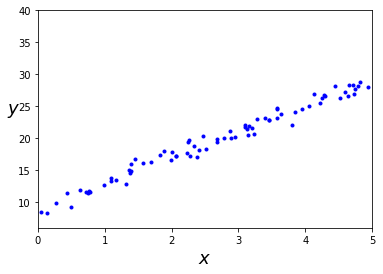

In [2]:
# Generate some data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = 7 * np.random.rand(100,1)
y = 9 + 4 * X+np.random.randn(100,1)

plt.plot(X,y,'b.')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
_ =plt.axis([0,5,6,40])

[0, 5, 6, 40]

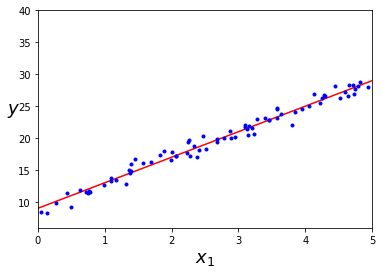

In [4]:
def linear_regression(X, y):
    X_b = np.c_[np.ones((len(X),1)), X]
    x_transpose_times_x = X_b.T.dot(X_b)
    inverse = np.linalg.inv(x_transpose_times_x)
    return inverse.dot(X_b.T).dot(y)
    
optimal_theta = linear_regression(X, y)
X_new = np.array([[0],[5]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(optimal_theta)
y_predict

plt.plot(X_new,y_predict,'r-')
plt.plot(X,y,'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,5,6,40])

As you can see with the power of linear algebra our solution becomes much easier to understand!  However, this only works because of the assumptions of linear regression.  This allows for a closed for solution.  Hopefully, this shows you the power of linear regression!

## Neural Networks

### A naive explanation

Neural networks in a sense really aren't anything new "mathematically".  All we are really doing is applying the chain rule over a vector space ( to do back propagation ).

Let's see a simple example of chain rules:

$$ f(x) = (log(x))^{2} $$

To do the derivative we need to do:

$$ f'(g(x)) = f'(g(x))* g'(x) $$

Therefore:

$$ f'(x) = 2 * log(x) * 1/x $$

So if our functions are over matrices then we are doing neural networks :D

### Psuedo Code

There are two main algorithms in neural networks:

* forward propagation ( predict )
* back propagation ( train )


![](nn_psuedocode.png)

[source](https://en.wikipedia.org/wiki/Artificial_neural_network)


As you can see the basic idea is:

* propagate data through a set of functions which are joined together via matrix multiplication

* At the last layer look at how much your prediction was off by

* update your weight matrix by the gradient * the error (this is a simplification)

* do this until your error is lower than some tolerance


## A Naive Implementation of a Neural Network

Now that we understand the basic notions, let's go ahead and look at a simple example in Python:


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

class Dense:
    def __init__(self, input_dim, output_dim, activation_function):
        self.synapse = 2 * np.random.random((input_dim, output_dim)) - 1 
        self.select_activation_function(activation_function)
        
    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, y):
        return 1 - y ** 2

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def dsigmoid(self, y):
        return y*(1-y)
    
    def select_activation_function(self, activation_function):
        if activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_derivative = self.dtanh
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_derivative = self.dsigmoid

    def forward(self, previous_layer):
        self.output = self.activation_function(
            previous_layer.dot(self.synapse)
        )
        return self.output
                           
    def compute_gradient(self, layer, error):
        self.delta = error * self.activation_derivative(layer)
        return self.delta.dot(self.synapse.T)

    def prepare_for_multiplication(self, vector):
        num_cols = len(vector)
        num_rows = 1
        return vector.reshape(num_rows, num_cols)

    def update_weights(self, layer, learning_rate):
        layer = self.prepare_for_multiplication(layer)
        delta = self.prepare_for_multiplication(self.delta)
        self.synapse += layer.T.dot(delta) * learning_rate


class Network:
    def __init__(self, layers):
        self.nn = layers
        self.layers = []
        
    def forward(self, X):
        self.layers = []
        self.layers.append(X)
        for index, synapse in enumerate(self.nn):
            output = synapse.forward(self.layers[index])
            self.layers.append(output)
        return output

    def backpropagate(self, error, learning_rate):
        layers = list(reversed(self.layers))
        nn = list(reversed(self.nn))
        for index, layer in enumerate(layers[:-1]):
            error = nn[index].compute_gradient(layer, error)

        for index, synapse in enumerate(self.nn):
            synapse.update_weights(self.layers[index], learning_rate)

        
class NeuralNetwork:
    def __init__(self, learning_rate=0.1, target_mse=0.01, epochs=500):
        self.layers = []
        self.connections = []
        self.network = None
        self.learning_rate = learning_rate
        self.target_mse = target_mse
        self.epochs = epochs
        self.errors = []
        
    def add_layer(self, layer):
        self.layers.append(layer)

    def init_network(self):
        self.network = Network(self.layers)

    def fit(self, X, y):
        self.init_network()
        for epoch in range(self.epochs):
            self.errors = []

            rows, columns = X.shape
            for index in range(rows):
                # Forward
                output = self.network.forward(X[index])
                # Compute the error
                error = y[index] - output
                self.errors.append(error)

                # Back-propagate the error
                self.network.backpropagate(error, self.learning_rate)

            mse = (np.array(self.errors) ** 2).mean()
            if mse <= self.target_mse:
                break

    def predict(self, X):
        return self.network.forward(X)

def data_generation_easy():
    df = pd.DataFrame()
    for _ in range(1000):
        a = np.random.normal(0, 1)
        b = np.random.normal(0, 3)
        c = np.random.normal(12, 4)
        if a + b + c > 11:
            target = 1
        else:
            target = 0
        df = df.append({
            "A": a,
            "B": b,
            "C": c,
            "target": target
        }, ignore_index=True)
    return df

df = data_generation_easy()
column_names = ["A", "B", "C"]
target_name = "target"
X = df[column_names].values
y = np.array([[elem] for elem in list(df["target"].values)])

nn = NeuralNetwork()
# Dense(inputs, outputs, activation)
nn.add_layer(Dense(3, 20, "tanh"))
nn.add_layer(Dense(20, 1, "tanh"))
nn.fit(X, y)
y_pred = nn.predict(X)
print(mean_squared_error(y_pred, y))

0.1892145506579259


## Setting up our network

As you can see from the above our naive neural network has three steps:

* Initialization
* forward propagation (guess)
* back propagation (check)

The initialization step sets up our neural network and the general architecture:

```python

class Dense:
    def __init__(self, input_dim, output_dim, activation_function):
        self.synapse = 2 * np.random.random((input_dim, output_dim)) - 1 
        self.select_activation_function(activation_function)

def init_network(self):
    self.network = Network(self.layers)

def add_layer(self, layer):
    self.layers.append(layer)
 
nn.add_layer(Dense(3, 20, "tanh"))
nn.add_layer(Dense(20, 1, "tanh"))
```

Creating a connection really means creating a randomly initialized matrix whose values will update over the course of back propagation.  We can see this in the `__init__` function in the `Dense` object.  The `init_network` function initializes the network once all the layers have been added.

As you can see, the shapes of our matrices will depend on the previous layer connecting to it - this is because we can only do matrix multiplication with composable shapes.

Our so called layers are actually the weight matrices that we will use to join each layer.

## Forward Propagation

Here we'll look at forward propagation through the network.  Forward propagation was a major innovation in the space of neural networks.  With it, we can compose layers together, creating vast and deep networks that can learn so much from the data.  Let's explore a naive implementation:

```python
def fit(self, X, y):
    self.init_network()
    for epoch in range(self.epochs):
        self.errors = []

        rows, columns = X.shape
        for index in range(rows):
            # Forward
            output = self.network.forward(X[index])
            
# in Network Object
def forward(self, X):
    self.layers = []
    self.layers.append(X)
    for index, synapse in enumerate(self.nn):
        output = synapse.forward(self.layers[index])
        self.layers.append(output)
    return output

# in Dense Object
def forward(self, previous_layer):
    self.output = self.activation_function(
        previous_layer.dot(self.synapse)
    )
    return self.output
```

forward propagation is called through the fit method.  In the network object, you can see synapses - which are the weight matrices of the network, being composed with the existing layers.  Notice that the weight matrices are the important thing for training the network, we simply discard the layers at each call of forward propagation.  

The layers are actually composed using the final forward method being shown above.  First, the dot product of the previous layer and the current synapse are taken and then an activation function is applied.  We can think of this operation as a non-linear transformation.  This is because a linear transformation is applied via the dot product and then a (typically) non-linear transformation is applied to that dot product.  It is possible to also use a linear transformation in as the activation function, but this means that the neural network will be unable to learn non-linear decision boundaries and therefore should be used with caution.  

Stepping back a bit, we can see forward propagation as a composition of layers via a non-linear transformation, where the layers on the connections and matrix multiplication and an activation function are used to update the weights across the network.  These operations are how information and decisions flow across the network.  We can see each layer as another opportunity to learn something, to update our beliefs about the world.  Also as an opportunity to throw away knowledge - this is primarily what the non-linearity does.  In this way, we can constrain ourselves to learning only the relevant information.  

As an aside, the size of a network determines how much it can learn, based on the above explaination.  As the size of the network grows it can learn more and more from the data.  This is obvious from the fact that there will be more decision makers per loop through each element of the data.  Additionally, as the size of our data grows, we will have more examples to learn from - which is why neural networks improve with more data.  So there are two tools for learning a better representation of your underlying process or distribution - build a bigger network or obtain more data.  Of course, there is a limit to how much this will improve things.  At some point, as the network grows, overfitting occurs, and the network merely memorizes the data.  

## Back Propagation

Back propagation is the second large innovation in neural networks we will discuss.  The way a neural network is trained, via back propagation means the interplay between the final output and error has a sophisticated and complex relationship with the weight space.  Because the weights at the end of the neural network, influence the nodes at the beginning of the neural network when error is propagated backwards. 

```python
def fit(self, X, y):
    self.init_network()
    for epoch in range(self.epochs):
        self.errors = []

        rows, columns = X.shape
        for index in range(rows):
            # Forward
            output = self.network.forward(X[index])
            # Compute the error
            error = y[index] - output
            self.errors.append(error)

            # Back-propagate the error
            self.network.backpropagate(error, self.learning_rate)

# in Network Object
def backpropagate(self, error, learning_rate):
    layers = list(reversed(self.layers))
    nn = list(reversed(self.nn))
    for index, layer in enumerate(layers[:-1]):
        error = nn[index].compute_gradient(layer, error)

    for index, synapse in enumerate(self.nn):
        synapse.update_weights(self.layers[index], learning_rate)

# in Dense Object
def compute_gradient(self, layer, error):
    self.delta = error * self.activation_derivative(layer)
    return self.delta.dot(self.synapse.T)

def prepare_for_multiplication(self, vector):
    num_cols = len(vector)
    num_rows = 1
    return vector.reshape(num_rows, num_cols)

def update_weights(self, layer, learning_rate):
    layer = self.prepare_for_multiplication(layer)
    delta = self.prepare_for_multiplication(self.delta)
    self.synapse += layer.T.dot(delta) * learning_rate        
```

As you can see back propagation takes on two stages:

* computing the gradient
* updating the weights

When computing the gradient the deltas, defined as the `error * activation_derivative(layer)`, are composed with the synapses via a dot product.  For clarity, the `activation_derivative` is the derivative of the activation function applied to the given layer.  We can think of a delta as the distance in the decision from an optimal decision.  

Of course, we don't know what an optimal decision looks like, however the error in the final layer from ground truth, calculated as `error = y[index] - output` in the `fit` function, gives us some notion of optimality.  Essentially, what this tells us is, we don't know all the nuance or pieces of information that lead from the data to the target.  

After the gradient has been computed, the weights are updated based on the dot product of the layer and delta.  We can think of this as trying to move the approximate amount we were off by, now in the correct direction.  The synapse or weight matrices, store the new more likely decision.  The learning rate we see there, is a discount factor, because any new information show always been taken with a grain of salt.  

In general, what the neural network tries to do, is take the data its given and the final decision that's produced and try to recreate the thought process that led to the underlying decision.  And it tries to do this in mathematically certain terms.  We can think of the gradient at each layer of the network, which we can think of as a layer of nuance, as telling us directionally guiding us towards a correct decision.  

One of the issues with this way of thinking about how to get closer to how a decision is made, is that the underlying curve of that gradient may be complex.  There may be lots of dead ends or wrong turns that the network takes, when trying to understand the underlying process.  This is why many examples are needed to really be sure you are moving in the right direction.  We can think of each row in our dataset as a piece of evidence and our network is like Sherlock Holmes.  It gather evidence, compares theories, and finally distills information down, into the most fitting explaination, no matter how improbable it appears at first glance.

## Issues in Neural Networks

There are two main types of issues with respect to neural networks:

* vanishing gradients
* exploding gradients

### Vanishing Gradient

The vanishing gradient problem is one of early stopping.  During back propagation the gradients can become increadibly small, due to the following simple fact:

When you multiple two small numbers they get very small very fast:

Example: 

`0.0005 * 0.0007 = 0.00000035`

So essentially what happens is, if the gradients ever head to an increasingly smaller value they will get extremely close to zero very fast.  

Unfortunately, the termination condition for training a neural network is similar to what happens when the gradient gets very small, so it's hard to tell if this is because the neural network has learned something or because the neural network accidentaly learned a weight early on that was small, which propagated to the whole system and led to early stopping

### Exploding Gradient

The exploding gradient has the opposite problem, it's when the gradients become very big very fast, because multiplying two big numbers, also creates a very big number very fast.  If that happens, it's unlikely the neural network will ever converge.

Both are issues, but explodiung gradients, luckily are super obvious because there is only one reason why that would happen.  That's why we only train a neural network for a fixed number of epochs.  This way, if indeed we do have a run away gradient, we'll know it happened and won't waste time training forever.


## Introduction to Keras

Now that we've seen how to work with the machinery of neural networks, let's start making use of our first library.  For this tutorial we will make use of Keras a great high level api for neural networks.

Let's start by looking at a simple regression example:

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation="linear"))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

crashes = sns.load_dataset("car_crashes")
y = crashes["total"]
X = crashes[["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium", "ins_losses"]]

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X, y)
y_pred = estimator.predict(X)
print(metrics.mean_squared_error(y, y_pred))

2.056991027049713


Notice, the following:

1. we need to set the number of input dimensions to be the same as the number of columns in our X variable.
2. we specify the loss in the compile phase as mean squared error.  With Neural networks we can even choose the loss metric!

Our model does pretty good!  It's worth noting that typically you should break things out into test and train sets, but more on that in a later chapter.  

Notice that the API for keras is very similar to the one we built - we build up `Dense` objects and add them to the overall model.  The big difference here is the output dimension comes first, and we need not specify an input dimension, because the keras API is smart enough to figure out your input dimension from your previous layer!!!  Which is pretty awesome.  

Finally, we have to "compile" our model vai `model.compile` so that all of our layers work together in the final model.  Here we get to choose our optimizer and loss function.  For regression problems mean squared error is typical, although other loss functions may make sense for your use case.  This will be described in detail in a later section.

Finally let's look at how we make use of our model:

```python
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X, y)
y_pred = estimator.predict(X)
```

This code should look pretty familar - keras comes with a scikit-learn wrapper object so we can use our keras model the same way we would use any scikit-learn model - by calling fit and predict methods.  The uniformity of this api means we can easily integrate neural networks into all our existing preprocessing, postprocessing and data visualization tools for scikit-learn, just like any other model.

Let's see a simple example of classification before we move onto interpreting our models:

In [48]:
from sklearn.datasets import load_iris
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

data = load_iris()
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
estimator.fit(data.data, data.target)
y_pred = estimator.predict(data.data)
print(metrics.classification_report(data.target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Again, unsurprisingly our model does quiet well!  But remember we shouldn't get too excited about this.  

Some important things to note as for differences between classification and regression:

1. The use of softmax in the final layer as apposed to linear for the activation function
2. The use of categorical cross entropy as apposed to mean squared error for loss
3. The use of the KerasClassifier object as apposed to the KerasRegressor object for object wrapping

Other than that, pretty much everything is the same.

Now let's move onto understanding the deeper points of building up your neural network architecture and talk through some common paradigms.  First we'll look at how to do this for regression and then classification.

## Neural Network Architecture

Now that we have the basics down, let's go over some of the architectural design elements of a neural network.  There are a few major components to tune:

* breadth of the network - how many neurons per layer
* the depth of the network - how many layers
* choosing the right activation function
* choosing how to split up the network - creating shared layers
* choosing the right weight initialization
* choosing the right loss function
* choosing the right optimizer
* choosing the right metric

First let's look at a simple example network and record the metrics and then see how the model performance changes as we vary the above parameters:


In [70]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.49      1.00      0.66       180

   micro avg       0.49      0.49      0.49       365
   macro avg       0.25      0.50      0.33       365
weighted avg       0.24      0.49      0.33       365

0.4931506849315068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This is the basic model setup for a model.  We have an input layer which has to have the same number of input dimensions as the number of columns in the independent variables, usually called.  And then we have an output layer which has to have an output dimension equal to the number of output possibilities.  For regression there should be one neuron in the final output, for classification there should be as many classes as the target variable.

Our model does okay, let's see if we can do better simply by increasing the number of layers:

In [69]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(10, input_dim=10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      1.00      0.63       166
           1       0.00      0.00      0.00       199

   micro avg       0.45      0.45      0.45       365
   macro avg       0.23      0.50      0.31       365
weighted avg       0.21      0.45      0.28       365

0.4547945205479452


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we can see we get some marginal improvement from increasing the number of layers.  Let's keep going to see if we continue to get improvement:

In [68]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(10, input_dim=10))
    model.add(Dense(10, input_dim=10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.52      1.00      0.69       191

   micro avg       0.52      0.52      0.52       365
   macro avg       0.26      0.50      0.34       365
weighted avg       0.27      0.52      0.36       365

0.5232876712328767


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We see some performance increase in some more categories.  Let's try adding a ton more layers to see if that continues to increase the performance:

In [67]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    for i in range(n):
        model.add(Dense(10, input_dim=10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
deep_model = partial(baseline_model, 20)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=deep_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       176
           1       0.00      0.00      0.00       189

   micro avg       0.48      0.48      0.48       365
   macro avg       0.24      0.50      0.33       365
weighted avg       0.23      0.48      0.31       365

0.4821917808219178


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It looks like our model performance has stopped increasing.  This may indicate that we have now reached a point of overfitting and therefore model performance won't continue to increase.  This speaks to a larger point - model performance won't continue to increase by just making our model deeper.  Let's take this knowledge add create a naive auto-ml function to optimize the depth of our network:

In [66]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial
from collections import defaultdict

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    for i in range(n):
        model.add(Dense(10, input_dim=10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def automl_basic(X_train, X_test, y_train, y_test, baseline, max_layers, num_runs = 3):
    accuracy_scores = defaultdict(list)
    for layers in range(max_layers):
        print("Number of hidden layers", layers)
        for i in range(num_runs):
            deep_model = partial(baseline, layers)
            estimator = KerasClassifier(build_fn=deep_model, epochs=100, batch_size=5, verbose=0)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            accuracy_scores[layers].append(metrics.accuracy_score(y_test, y_pred))
    return accuracy_scores

def choose_best_model(accuracy_scores, max_layers):
    best_acc = 0
    best_hidden_layers = 0
    for layers in range(max_layers):
        cur_acc = np.mean(accuracy_scores[layers])
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_hidden_layers = layers
    return best_acc, best_hidden_layers

random.seed(1)

df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
max_layers = 5
accuracy_scores = automl_basic(X_train, X_test, y_train, y_test, baseline_model, max_layers, num_runs=5)
best_acc, best_hidden_layers = choose_best_model(accuracy_scores, max_layers)
print("Optimal number of hidden layers", best_hidden_layers)
print("Optimal accuracy", best_acc)

Number of hidden layers 0
Number of hidden layers 1
Number of hidden layers 2
Number of hidden layers 3
Number of hidden layers 4
Optimal number of hidden layers 2
Optimal accuracy 0.5024657534246575


As you can see the optimal number of layers is 2.  Unfortunately our naive implementation does take a while to run, so if you want to verify the consistency here, proceed with caution.

Now that we've looked at increasing the depth of our network, let's look at increasing the breadth.  For this set of experiments, will simply use a single hidden layer. 

In [71]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(n, input_dim=10))
    model.add(Dense(n))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
broad_model = partial(baseline_model, 10)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=broad_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       178
           1       0.00      0.00      0.00       187

   micro avg       0.49      0.49      0.49       365
   macro avg       0.24      0.50      0.33       365
weighted avg       0.24      0.49      0.32       365

0.4876712328767123


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now that we have our baseline, let's see if we can improve upon that by adding more neurons in our single hidden layer.

In [72]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(n, input_dim=10))
    model.add(Dense(n))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
broad_model = partial(baseline_model, 15)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=broad_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.49      1.00      0.66       180

   micro avg       0.49      0.49      0.49       365
   macro avg       0.25      0.50      0.33       365
weighted avg       0.24      0.49      0.33       365

0.4931506849315068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It looks like we got a small improvement!  Let's try doing the same automl game, except this time for breadth:

In [13]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial
from collections import defaultdict

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(n, input_dim=10))
    model.add(Dense(n))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def automl_basic(X_train, X_test, y_train, y_test, baseline, min_neurons, max_neurons, num_runs = 5):
    accuracy_scores = defaultdict(list)
    for neurons in range(min_neurons, max_neurons):
        print("Number of hidden layers", neurons)
        for i in range(num_runs):
            deep_model = partial(baseline, neurons)
            estimator = KerasClassifier(build_fn=deep_model, epochs=100, batch_size=5, verbose=0)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            accuracy_scores[neurons].append(metrics.accuracy_score(y_test, y_pred))
    return accuracy_scores

def choose_best_model(accuracy_scores, min_neurons, max_neurons):
    best_acc = 0
    best_neurons = 0
    for neurons in range(min_neurons, max_neurons):
        cur_acc = np.mean(accuracy_scores[neurons])
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_neurons = neurons
    return best_acc, best_neurons

random.seed(1)

df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
min_neurons = 8
max_neurons = 13 
accuracy_scores = automl_basic(X_train, X_test, y_train, y_test, baseline_model, min_neurons, max_neurons, num_runs=2)
best_acc, best_neurons = choose_best_model(accuracy_scores, min_neurons, max_neurons)
print("Optimal number of neurons", best_neurons)
print("Optimal accuracy", best_acc)

Number of hidden layers 8
Number of hidden layers 9
Number of hidden layers 10
Number of hidden layers 11
Number of hidden layers 12
Optimal number of neurons 12
Optimal accuracy 0.5205479452054794


Looks like 12 does the best!  Finally, let's see what happens when we combine the two approaches together.  Using this will get a sense of the optimal capacity of the network:

In [ ]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial
from collections import defaultdict
import itertools

def baseline_model(neurons, layers):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=10))
    for _ in range(layers):
        model.add(Dense(neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def automl_basic(X_train, X_test, y_train, y_test, baseline, min_neurons, max_neurons, max_layers, num_runs = 3):
    accuracy_scores = defaultdict(list)
    for layers_neurons in itertools.product(range(max_layers), range(min_neurons, max_neurons)):
        layers = layers_neurons[0]
        neurons = layers_neurons[1]
        print("Number of hidden layers", layers)
        for i in range(num_runs):
            deep_broad_model = partial(baseline, neurons, layers)
            estimator = KerasClassifier(build_fn=deep_broad_model, epochs=100, batch_size=5, verbose=0)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            accuracy_scores[layers_neurons].append(metrics.accuracy_score(y_test, y_pred))
    return accuracy_scores

def choose_best_model(accuracy_scores, min_neurons, max_neurons, max_layers):
    best_acc = 0
    best_layers = 0
    best_neurons = 0
    for layers_neurons in itertools.product(range(max_layers), range(min_neurons, max_neurons)):
        cur_acc = np.mean(accuracy_scores[layers_neurons])
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_layers = layers_neurons[0]
            best_neurons = layers_neurons[1]
    return best_acc, best_layers, best_neurons

random.seed(1)

df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
min_neurons = 8
max_neurons = 13
max_layers = 10
accuracy_scores = automl_basic(X_train, X_test, y_train, y_test, baseline_model, min_neurons, max_neurons, max_layers, num_runs=2)
best_acc, best_layers, best_neurons = choose_best_model(accuracy_scores, min_neurons, max_neurons, max_layers)
print("Optimal number of hidden layers", best_layers)
print("Optimal number of neurons per layer", best_neurons)
print("Optimal accuracy", best_acc)

Because the code is pretty slow on a single computer I had to run it on a cluster, you can see the results below:
```
Optimal number of hidden layers 0
Optimal number of neurons per layer 11
Optimal accuracy 0.5041095890410959
```
## Exploring Different Models

So far we've looked at models where the number of neurons per layer have been constant.  Now we'll look at a few ideas for changing the number of neurons per layer.  First we'll look at a "pyramid" network where the number of neurons is large at the start of the network and the number of neurons gets small towards the end.

In [2]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
import pandas as pd
from functools import partial

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.55      1.00      0.71       202

   micro avg       0.55      0.55      0.55       365
   macro avg       0.28      0.50      0.36       365
weighted avg       0.31      0.55      0.39       365

0.5534246575342465


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As you can see we get a performance boost just by changing the structure of the neurons.  Let's see if we can do better by making the network deeper, by keeping the same general structure: 

In [10]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
import pandas as pd
from functools import partial

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(8))
    model.add(Dense(5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       184
           1       0.00      0.00      0.00       181

   micro avg       0.50      0.50      0.50       365
   macro avg       0.25      0.50      0.34       365
weighted avg       0.25      0.50      0.34       365

0.5041095890410959


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As you can see this has diminishing returns.  Next we will look at a "christmas tree" network that starts out thin and then gets fat.

In [11]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
import pandas as pd
from functools import partial

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(1, input_dim=10))
    model.add(Dense(3))
    model.add(Dense(5))
    model.add(Dense(10))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.47      1.00      0.64       170

   micro avg       0.47      0.47      0.47       365
   macro avg       0.23      0.50      0.32       365
weighted avg       0.22      0.47      0.30       365

0.4657534246575342


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can see that the christmas tree model does somewhat worse.  Next we'll look at increasing and decreasing the number of nodes over the layers:

In [12]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
import pandas as pd
from functools import partial

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(5))
    model.add(Dense(10))
    model.add(Dense(5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       175
           1       0.52      1.00      0.69       190

   micro avg       0.53      0.53      0.53       365
   macro avg       0.76      0.51      0.35       365
weighted avg       0.75      0.53      0.37       365

0.5260273972602739


As you can see this increasing decreasing network does really well on the data!  Let's see if increasing the depth can be optmized.  For this we'll make use of our automl toolset.

In [14]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
from functools import partial
from collections import defaultdict

%matplotlib inline

def baseline_model(n):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10))
    model.add(Dense(5))
    for i in range(n):
        model.add(Dense(10))
        model.add(Dense(5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def automl_basic(X_train, X_test, y_train, y_test, baseline, max_layers, num_runs = 3):
    accuracy_scores = defaultdict(list)
    for layers in range(max_layers):
        print("Number of hidden layers", layers)
        for i in range(num_runs):
            deep_model = partial(baseline, layers)
            estimator = KerasClassifier(build_fn=deep_model, epochs=100, batch_size=5, verbose=0)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            accuracy_scores[layers].append(metrics.accuracy_score(y_test, y_pred))
    return accuracy_scores

def choose_best_model(accuracy_scores, max_layers):
    best_acc = 0
    best_hidden_layers = 0
    for layers in range(max_layers):
        cur_acc = np.mean(accuracy_scores[layers])
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_hidden_layers = layers
    return best_acc, best_hidden_layers

random.seed(1)

df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
max_layers = 7
accuracy_scores = automl_basic(X_train, X_test, y_train, y_test, baseline_model, max_layers, num_runs=5)
best_acc, best_hidden_layers = choose_best_model(accuracy_scores, max_layers)
print("Optimal number of hidden layers", best_hidden_layers)
print("Optimal accuracy", best_acc)

Number of hidden layers 0
Number of hidden layers 1
Number of hidden layers 2
Number of hidden layers 3
Number of hidden layers 4
Number of hidden layers 5
Number of hidden layers 6
Optimal number of hidden layers 1
Optimal accuracy 0.5024657534246575


As we can see as we continue to add layers the model performance does not improve.  So we can see there are diminishing returns to this pattern.  Next let's look at another pattern where the network starts off broad, goes narrow and then goes broad again.  

In [19]:
from sklearn import ensemble
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import model_selection
import random
import pandas as pd
from functools import partial

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=10))
    model.add(Dense(1))
    model.add(Dense(1))
    model.add(Dense(100))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       186
           1       0.00      0.00      0.00       179

   micro avg       0.51      0.51      0.51       365
   macro avg       0.25      0.50      0.34       365
weighted avg       0.26      0.51      0.34       365

0.5095890410958904


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Interestingly, by constraining the network in another way we get to 100% recall for the zero label.  Now let's see if we can combine two networks to increase performance.  In order to do this we'll make use of the keras functional API and make use of shared layers.

In [48]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

def baseline_model():
    # first input model
    visible = Input(shape=(10,))
    dense11 = Dense(10)(visible)
    dense12 = Dense(5)(dense11)
    dense13 = Dense(10)(dense12)
    dense14 = Dense(5)(dense13)

    # second input model
    dense21 = Dense(100)(visible)
    dense22 = Dense(1)(dense21)
    dense23 = Dense(1)(dense22)
    dense24 = Dense(100)(dense23)
    # merge input models
    merge = concatenate([dense14, dense24])
    output = Dense(2, activation='sigmoid')(merge)

    model = Model(inputs=visible, 
                  outputs=output) 
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

random.seed(1)
# data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
df = pd.read_csv("housepricedata.csv")
X = df.values[:,0:10]
y = df.values[:,10]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       176
           1       0.00      0.00      0.00       189

   micro avg       0.48      0.48      0.48       365
   macro avg       0.24      0.50      0.33       365
weighted avg       0.23      0.48      0.31       365

0.4821917808219178


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Unfortunately the functional API doesn't yield results that are any better.  Now that we've explored a number of architectures, let's next look at activation functions which can help constrain our data to make the decision boundary clearer.

## Activation Functions

As we saw in our naive implementation these activation functions are fairly simple.  Let's look at some naive implementations of each of these activations to look for common ground.  Then we'll make use of activation functions in a myriad of ways to attempt to improve performance.

In [ ]:
def linear(x, constant=3):
    return x*constant

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    return np.exp(x) / sum(np.exp(x))

def leaky_relu(x, alpha):
    return [alpha*elem if elem < 0 else elem for elem in x]

def elu(x, alpha):
    return [alpha * np.exp(elem) - 1 
            if elem <= 0 else elem 
            for elem in x]

def relu(x):
    return [0 if elem <= 0 else elem 
            for elem in x]


These are the standard activation functions folks tend to use

Are there are any common features of the functions we've defined?

The Leaky RELU, the ELU, and the RELU all have a ternary operator.

Read these:
* https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0
* https://en.wikipedia.org/wiki/Activation_function
* https://en.wikipedia.org/wiki/Perceptron
* https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

## Weight Initialization

Read these:
* https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78
* https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
* https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network
* https://isaacchanghau.github.io/post/weight_initialization/
* http://cs231n.github.io/neural-networks-2/
https://arxiv.org/abs/1704.08863

## Surogate Models

## SHAP

References:
* https://datascience.stackexchange.com/questions/10000/what-is-the-difference-between-a-dynamic-bayes-network-and-a-hmm
* https://machinelearningmastery.com/keras-functional-api-deep-learning/
* data found here: https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4